# Purkinje Cell Density Analysis
## Analysis of Purkinje Cell Number vs Normalized Area for Control vs NEC Samples
This notebook analyzes Purkinje cell measurements and creates density ratios comparing Control (C) and NEC (N) mouse samples.

## 1. Import Required Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set output directory
output_dir = Path('/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_pc/output')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {output_dir}")

# Create a function to save figures
def save_figure(fig_name, fig=None, dpi=300):
    """Save the current figure as PDF in the output directory"""
    if fig is None:
        fig = plt.gcf()
    output_path = output_dir / f"{fig_name}.pdf"
    plt.savefig(output_path, format='pdf', dpi=dpi, bbox_inches='tight')
    print(f"Saved: {output_path.name}")

Output directory set to: /Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_pc/output


## 2. Load and Initial Data Exploration

In [62]:
# Define file path for the new dataset
csv_file_path = '/Users/rvidva/Library/CloudStorage/OneDrive-ChildrensNationalHospital/co-workspace/neuropath_visium_pc/measurements_with_calculations.csv'

# Load the data
print("Loading data from CSV file...")
df = pd.read_csv(csv_file_path)

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Check for required columns
required_columns = ['Purkinje_Number', 'Normalized_Purkinje_Area']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"\nWarning: Missing required columns: {missing_columns}")
else:
    print(f"\nAll required columns found: {required_columns}")

Loading data from CSV file...

Dataset shape: (354, 24)
Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Area µm^2', 'Perimeter µm', 'ML_IGL_Perimeter', 'Half_Perimeter', 'Raw_EGL_Area', 'Raw_IGL_Area', 'Raw_ML_Area', 'Raw_WM_Area', 'Norm_EGL_Area', 'Norm_IGL_Area', 'Norm_ML_Area', 'Norm_WM_Area', 'Purkinje_Area', 'Normalized_Purkinje_Area', 'Purkinje_Number']

First few rows:
                      Image                             Object ID Object type  \
0  C1M1B1_1.vsi - 20x_BF_01  005e9d66-f7e2-46e1-a5f6-c63e85aa047a  Annotation   
1  C1M1B1_1.vsi - 20x_BF_01  d1b46a65-f07c-468f-a0ba-645dbf4f7beb  Annotation   
2  C1M1B1_1.vsi - 20x_BF_01  fc540572-9034-4477-8a31-d3a29231e143  Annotation   
3  C1M1B1_1.vsi - 20x_BF_01  3344aac1-7f1b-46f6-86ca-301547d9f07a  Annotation   
4  C1M1B1_1.vsi - 20x_BF_01  74b6cea9-e573-4894-95f9-008d974474cd  Annotation   

    Name Classification               Parent       ROI  C

## 3. Data Preprocessing
### 3.1 Extract Sample Information and Filter Data

In [63]:
# Exclude 60x images if present
print("Checking for 60x images...")
if df['Image'].str.contains('60x').any():
    print(f"Number of rows before excluding 60x images: {len(df)}")
    df = df[~df['Image'].str.contains('60x')]
    print(f"Number of rows after excluding 60x images: {len(df)}")
else:
    print("No 60x images found.")

# Filter for only Control (C) and NEC (N) samples
print(f"\nNumber of rows before filtering for C/N samples: {len(df)}")
df = df[df['Image'].str.startswith(('N', 'C'))]
print(f"Number of rows after filtering for C/N samples: {len(df)}")

# Extract sample information from Image column
df['Sample_full'] = df['Image'].str.extract(r'([CN]\d+M\d+B\d+)', expand=False)
df['Image_num'] = df['Image'].str.extract(r'[CN]\d+M\d+B\d+_(\d+[a-zA-Z]?)\.vsi', expand=False)
df['Image_num'] = df['Image_num'].fillna('0')
df['Sample_type'] = df['Sample_full'].str[0].map({'C': 'Control', 'N': 'NEC'})

# Display extraction results
print("\nSample extraction results:")
print(df[['Image', 'Sample_full', 'Image_num', 'Sample_type']].head(10))

# Show sample distribution
print("\nSample type distribution:")
print(df.groupby('Sample_type')['Sample_full'].nunique())

# List all samples
control_samples = sorted(df[df['Sample_type'] == 'Control']['Sample_full'].unique())
nec_samples = sorted(df[df['Sample_type'] == 'NEC']['Sample_full'].unique())

print(f"\nControl samples (n={len(control_samples)}): {control_samples}")
print(f"NEC samples (n={len(nec_samples)}): {nec_samples}")

Checking for 60x images...
Number of rows before excluding 60x images: 354
Number of rows after excluding 60x images: 330

Number of rows before filtering for C/N samples: 330
Number of rows after filtering for C/N samples: 240

Sample extraction results:
                       Image Sample_full Image_num Sample_type
0   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
1   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
2   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
3   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
4   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
5   C1M1B1_1.vsi - 20x_BF_01      C1M1B1         1     Control
18  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
19  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
20  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control
21  C1M2B1_1.vsi - 20x_BF_01      C1M2B1         1     Control

Sample type distribution:
Sample_type
Control    8

### 3.2 Optional: Exclude Specific Sample IDs

In [65]:
# Define samples to exclude (modify this list as needed)
SAMPLES_TO_EXCLUDE = ['C2M1B1']  # Example: ['C2M1B1', 'N1M2B1']

if SAMPLES_TO_EXCLUDE:
    print(f"\nExcluding the following samples from analysis: {SAMPLES_TO_EXCLUDE}")
    print(f"Rows before exclusion: {len(df)}")
    
    # Remove specified samples
    df = df[~df['Sample_full'].isin(SAMPLES_TO_EXCLUDE)]
    
    print(f"Rows after exclusion: {len(df)}")
    
    # Show updated sample counts
    print("\nUpdated sample counts:")
    print(df.groupby('Sample_type')['Sample_full'].nunique())
    
    # List remaining samples
    remaining_control = sorted(df[df['Sample_type'] == 'Control']['Sample_full'].unique())
    remaining_nec = sorted(df[df['Sample_type'] == 'NEC']['Sample_full'].unique())
    
    print(f"\nRemaining Control samples: {remaining_control}")
    print(f"Remaining NEC samples: {remaining_nec}")
else:
    print("\nNo samples excluded - analyzing all samples")


Excluding the following samples from analysis: ['C2M1B1']
Rows before exclusion: 240
Rows after exclusion: 234

Updated sample counts:
Sample_type
Control    7
NEC        9
Name: Sample_full, dtype: int64

Remaining Control samples: ['C1M1B1', 'C1M2B1', 'C1M3B1', 'C1M4B1', 'C2M2B1', 'C2M3B1', 'C2M5B1']
Remaining NEC samples: ['N11M1B2', 'N11M2B1', 'N11M3B1', 'N11M3B2', 'N11M6B1', 'N11M6B2', 'N12M5B1', 'N13M2B1', 'N13M3B1']


## 4. Focus on Purkinje Cell Data and Calculate Density Ratio

In [66]:
# Filter for PurkinjeCell data only (since we're focusing on Purkinje cell analysis)
purkinje_df = df[df['Classification'] == 'PurkinjeCell'].copy()

print(f"Purkinje cell data shape: {purkinje_df.shape}")
print(f"Samples with Purkinje data: {purkinje_df['Sample_full'].nunique()}")

# Check data availability
print("\nPurkinje data by sample type:")
print(purkinje_df.groupby('Sample_type')['Sample_full'].nunique())

# Display sample Purkinje data
print("\nSample Purkinje cell measurements:")
print(purkinje_df[['Sample_full', 'Sample_type', 'Purkinje_Number', 'Normalized_Purkinje_Area', 'Image_num']].head(10))

# Check for missing values in key columns
print("\nMissing values check:")
print(f"Purkinje_Number missing: {purkinje_df['Purkinje_Number'].isna().sum()}")
print(f"Normalized_Purkinje_Area missing: {purkinje_df['Normalized_Purkinje_Area'].isna().sum()}")

# Remove rows with missing essential data
initial_rows = len(purkinje_df)
purkinje_df = purkinje_df.dropna(subset=['Purkinje_Number', 'Normalized_Purkinje_Area'])
final_rows = len(purkinje_df)

if initial_rows != final_rows:
    print(f"\nRemoved {initial_rows - final_rows} rows with missing Purkinje data")

Purkinje cell data shape: (39, 27)
Samples with Purkinje data: 16

Purkinje data by sample type:
Sample_type
Control    7
NEC        9
Name: Sample_full, dtype: int64

Sample Purkinje cell measurements:
   Sample_full Sample_type  Purkinje_Number  Normalized_Purkinje_Area  \
2       C1M1B1     Control       615.331111                  2.150764   
23      C1M2B1     Control       576.120000                  2.206239   
28      C1M2B1     Control       435.448889                  1.716754   
34      C1M3B1     Control       734.153333                  2.728947   
40      C1M3B1     Control       533.248889                  1.674882   
57      C1M4B1     Control       801.308889                  2.748968   
63      C1M4B1     Control       571.904444                  2.077621   
68     N11M3B2         NEC      1152.960000                  3.728507   
76     N11M6B1         NEC       333.831111                  1.530505   
83     N11M6B1         NEC       342.791111                  1.7316

## 5. Calculate Purkinje Cell Density Ratio

In [67]:
# Calculate the Purkinje density ratio: Purkinje_Number / Normalized_Purkinje_Area
print("Calculating Purkinje cell density ratio...")

# Ensure numeric data types
purkinje_df['Purkinje_Number'] = pd.to_numeric(purkinje_df['Purkinje_Number'], errors='coerce')
purkinje_df['Normalized_Purkinje_Area'] = pd.to_numeric(purkinje_df['Normalized_Purkinje_Area'], errors='coerce')

# Calculate density ratio (avoid division by zero)
purkinje_df['Purkinje_Density_Ratio'] = np.where(
    purkinje_df['Normalized_Purkinje_Area'] > 0,
    purkinje_df['Purkinje_Number'] / purkinje_df['Normalized_Purkinje_Area'],
    np.nan
)

# Check for any issues with the calculation
print(f"\nDensity ratio calculation results:")
print(f"Valid ratios calculated: {purkinje_df['Purkinje_Density_Ratio'].notna().sum()}")
print(f"Invalid ratios (NaN): {purkinje_df['Purkinje_Density_Ratio'].isna().sum()}")

# Remove any rows with invalid ratios
purkinje_df = purkinje_df.dropna(subset=['Purkinje_Density_Ratio'])

# Display statistics
print(f"\nPurkinje Density Ratio Statistics:")
print(f"Mean: {purkinje_df['Purkinje_Density_Ratio'].mean():.4f}")
print(f"Std: {purkinje_df['Purkinje_Density_Ratio'].std():.4f}")
print(f"Range: {purkinje_df['Purkinje_Density_Ratio'].min():.4f} - {purkinje_df['Purkinje_Density_Ratio'].max():.4f}")

Calculating Purkinje cell density ratio...

Density ratio calculation results:
Valid ratios calculated: 39
Invalid ratios (NaN): 0

Purkinje Density Ratio Statistics:
Mean: 260.4103
Std: 52.5943
Range: 195.6656 - 430.6089


## 6. Average Multiple Images per Sample

In [68]:
# If there are multiple images per sample, average them
print("Averaging multiple images per sample...")

# Check for multiple images per sample
sample_image_counts = purkinje_df.groupby('Sample_full').size()
multi_image_samples = sample_image_counts[sample_image_counts > 1]

if len(multi_image_samples) > 0:
    print(f"\nSamples with multiple images:")
    for sample, count in multi_image_samples.items():
        print(f"  {sample}: {count} images")
    
    # Average the measurements for samples with multiple images
    averaged_df = purkinje_df.groupby(['Sample_full', 'Sample_type']).agg({
        'Purkinje_Number': 'mean',
        'Normalized_Purkinje_Area': 'mean',
        'Purkinje_Density_Ratio': 'mean'
    }).reset_index()
    
    print(f"\nAfter averaging: {len(averaged_df)} unique samples")
else:
    print("No samples with multiple images found.")
    averaged_df = purkinje_df[['Sample_full', 'Sample_type', 'Purkinje_Number', 
                               'Normalized_Purkinje_Area', 'Purkinje_Density_Ratio']].copy()

# Display final dataset
print(f"\nFinal dataset shape: {averaged_df.shape}")
print("\nFinal data summary:")
print(averaged_df.groupby('Sample_type').agg({
    'Purkinje_Number': ['count', 'mean', 'std'],
    'Normalized_Purkinje_Area': ['mean', 'std'],
    'Purkinje_Density_Ratio': ['mean', 'std']
}).round(4))

Averaging multiple images per sample...

Samples with multiple images:
  C1M2B1: 2 images
  C1M3B1: 2 images
  C1M4B1: 2 images
  N11M1B2: 4 images
  N11M2B1: 6 images
  N11M3B2: 6 images
  N11M6B1: 6 images
  N11M6B2: 3 images

After averaging: 16 unique samples

Final dataset shape: (16, 5)

Final data summary:
            Purkinje_Number                     Normalized_Purkinje_Area  \
                      count      mean       std                     mean   
Sample_type                                                                
Control                   7  516.6262  157.4703                   1.7486   
NEC                       9  533.8577  235.5420                   2.0331   

                    Purkinje_Density_Ratio           
                std                   mean      std  
Sample_type                                          
Control      0.6296               305.4371  36.8517  
NEC          0.7150               257.6553  39.0939  


## 7. Statistical Analysis: Control vs NEC Comparison

In [69]:
print("Statistical Analysis: Control vs NEC Comparison")
print("="*60)

# Separate data by sample type
control_data = averaged_df[averaged_df['Sample_type'] == 'Control']
nec_data = averaged_df[averaged_df['Sample_type'] == 'NEC']

print(f"\nSample sizes:")
print(f"Control: n = {len(control_data)}")
print(f"NEC: n = {len(nec_data)}")

# Analyze each metric
metrics = ['Purkinje_Number', 'Normalized_Purkinje_Area', 'Purkinje_Density_Ratio']
metric_labels = ['Purkinje Cell Number', 'Normalized Purkinje Area', 'Purkinje Density Ratio']

for metric, label in zip(metrics, metric_labels):
    print(f"\n{label}:")
    print("-" * 40)
    
    control_values = control_data[metric].dropna()
    nec_values = nec_data[metric].dropna()
    
    if len(control_values) > 0 and len(nec_values) > 0:
        print(f"Control: n={len(control_values)}, mean={control_values.mean():.4f}, std={control_values.std():.4f}")
        print(f"NEC: n={len(nec_values)}, mean={nec_values.mean():.4f}, std={nec_values.std():.4f}")
        
        # Perform statistical test
        if len(control_values) >= 3 and len(nec_values) >= 3:
            # Check normality
            _, p_control = stats.shapiro(control_values)
            _, p_nec = stats.shapiro(nec_values)
            
            print(f"Normality tests - Control: p={p_control:.4f}, NEC: p={p_nec:.4f}")
            
            # Use Mann-Whitney U test (non-parametric)
            statistic, p_value = stats.mannwhitneyu(control_values, nec_values, alternative='two-sided')
            
            print(f"Mann-Whitney U test: U={statistic:.4f}, p={p_value:.4f}")
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((control_values.std()**2 + nec_values.std()**2) / 2)
            if pooled_std > 0:
                cohens_d = (control_values.mean() - nec_values.mean()) / pooled_std
                print(f"Cohen's d: {cohens_d:.4f}")
            
            # Significance level
            if p_value < 0.001:
                sig_level = "***"
            elif p_value < 0.01:
                sig_level = "**"
            elif p_value < 0.05:
                sig_level = "*"
            else:
                sig_level = "ns"
            
            print(f"Significance: {sig_level}")

Statistical Analysis: Control vs NEC Comparison

Sample sizes:
Control: n = 7
NEC: n = 9

Purkinje Cell Number:
----------------------------------------
Control: n=7, mean=516.6262, std=157.4703
NEC: n=9, mean=533.8577, std=235.5420
Normality tests - Control: p=0.2851, NEC: p=0.4300
Mann-Whitney U test: U=29.0000, p=0.8371
Cohen's d: -0.0860
Significance: ns

Normalized Purkinje Area:
----------------------------------------
Control: n=7, mean=1.7486, std=0.6296
NEC: n=9, mean=2.0331, std=0.7150
Normality tests - Control: p=0.2670, NEC: p=0.1442
Mann-Whitney U test: U=22.0000, p=0.3510
Cohen's d: -0.4224
Significance: ns

Purkinje Density Ratio:
----------------------------------------
Control: n=7, mean=305.4371, std=36.8517
NEC: n=9, mean=257.6553, std=39.0939
Normality tests - Control: p=0.7865, NEC: p=0.7533
Mann-Whitney U test: U=50.0000, p=0.0549
Cohen's d: 1.2578
Significance: ns


## 8. Create Box Plots for Purkinje Cell Metrics

Saved: purkinje_cell_analysis_boxplots.pdf


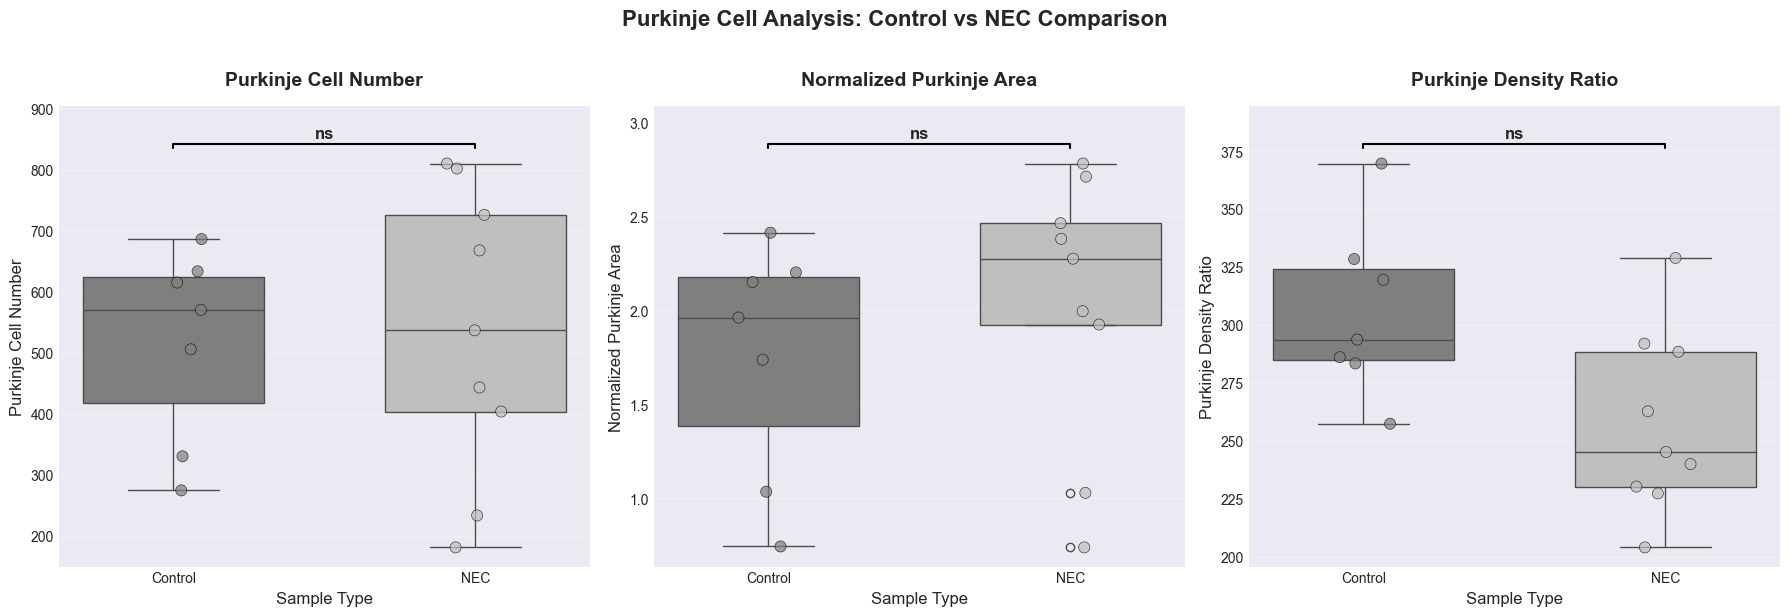

In [75]:
# Set up the plotting parameters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define grayscale colors with slight transparency for better appearance
control_color = '#7f7f7f'  # Medium gray
nec_color = '#bfbfbf'     # Light gray
control_color_alpha = '#7f7f7fcc'  # Medium gray with transparency
nec_color_alpha = '#bfbfbfcc'     # Light gray with transparency

# Define colors
palette = {'Control': control_color, 'NEC': nec_color}

# Create box plots for each metric
for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx]
    
    # Prepare data for this metric
    plot_data = averaged_df[['Sample_type', metric]].dropna()
    
    if len(plot_data) > 0:
        # Create box plot
        sns.boxplot(data=plot_data, x='Sample_type', y=metric, 
                   palette=palette, ax=ax, width=0.6)
        
        # Add individual points with jitter
        sns.stripplot(data=plot_data, x='Sample_type', y=metric,
                     palette=palette, ax=ax, size=8, alpha=0.7,
                     edgecolor='black', linewidth=0.5)
        
        # Calculate statistics for significance testing
        control_vals = plot_data[plot_data['Sample_type'] == 'Control'][metric]
        nec_vals = plot_data[plot_data['Sample_type'] == 'NEC'][metric]
        
        # Add significance bracket if we have enough data
        if len(control_vals) >= 3 and len(nec_vals) >= 3:
            _, p_value = stats.mannwhitneyu(control_vals, nec_vals, alternative='two-sided')
            
            # Calculate bracket position
            y_max = plot_data[metric].max()
            y_min = plot_data[metric].min()
            y_range = y_max - y_min
            y_bracket = y_max + 0.05 * y_range
            
            # Draw significance bracket
            ax.plot([0, 0, 1, 1], 
                   [y_bracket - 0.01 * y_range, y_bracket, y_bracket, y_bracket - 0.01 * y_range], 
                   'k-', linewidth=1.5)
            
            # Add significance text
            if p_value < 0.001:
                sig_text = "***"
            elif p_value < 0.01:
                sig_text = "**"
            elif p_value < 0.05:
                sig_text = "*"
            else:
                sig_text = "ns"
            
            ax.text(0.5, y_bracket + 0.01 * y_range, sig_text, 
                   ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            # Adjust y-axis to accommodate significance bracket
            ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.15 * y_range)
        
        # Customize subplot
        ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Sample Type', fontsize=12)
        ax.set_ylabel(label, fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Main title
plt.suptitle('Purkinje Cell Analysis: Control vs NEC Comparison', 
             fontsize=16, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()

# Save figure
save_figure('purkinje_cell_analysis_boxplots')
plt.show()


## 9. Create Focused Box Plot for Purkinje Density Ratio

Saved: purkinje_density_ratio_focused_boxplot.pdf


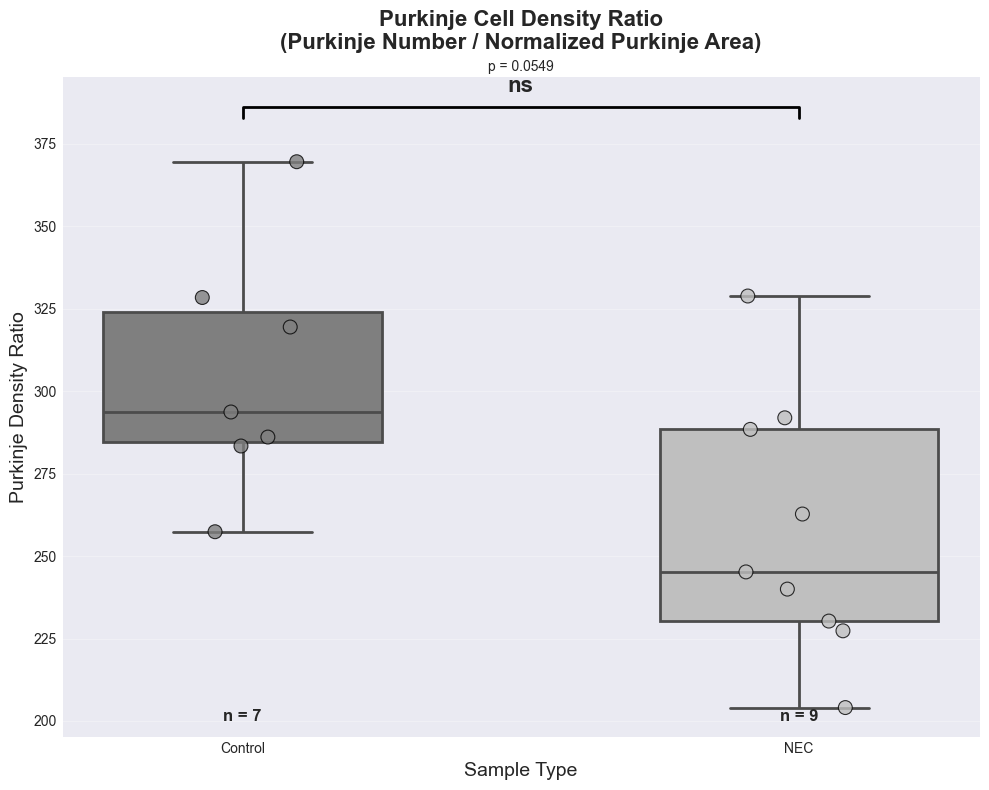

In [76]:
# Create a focused plot for the main metric of interest
plt.figure(figsize=(10, 8))

# Prepare data for density ratio
density_data = averaged_df[['Sample_type', 'Purkinje_Density_Ratio']].dropna()

# Create enhanced box plot
ax = sns.boxplot(data=density_data, x='Sample_type', y='Purkinje_Density_Ratio',
                palette=palette, width=0.5, linewidth=2)

# Add individual points with better styling
sns.stripplot(data=density_data, x='Sample_type', y='Purkinje_Density_Ratio',
             palette=palette, size=10, alpha=0.8, 
             edgecolor='black', linewidth=0.8)

# Calculate and display statistics
control_density = density_data[density_data['Sample_type'] == 'Control']['Purkinje_Density_Ratio']
nec_density = density_data[density_data['Sample_type'] == 'NEC']['Purkinje_Density_Ratio']

if len(control_density) >= 3 and len(nec_density) >= 3:
    _, p_value = stats.mannwhitneyu(control_density, nec_density, alternative='two-sided')
    
    # Add significance bracket
    y_max = density_data['Purkinje_Density_Ratio'].max()
    y_min = density_data['Purkinje_Density_Ratio'].min()
    y_range = y_max - y_min
    y_bracket = y_max + 0.1 * y_range
    
    # Draw bracket
    plt.plot([0, 0, 1, 1], 
            [y_bracket - 0.02 * y_range, y_bracket, y_bracket, y_bracket - 0.02 * y_range], 
            'k-', linewidth=2)
    
    # Add significance text
    if p_value < 0.001:
        sig_text = "***"
    elif p_value < 0.01:
        sig_text = "**"
    elif p_value < 0.05:
        sig_text = "*"
    else:
        sig_text = "ns"
    
    plt.text(0.5, y_bracket + 0.02 * y_range, sig_text, 
            ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    # Add p-value text
    plt.text(0.5, y_bracket + 0.06 * y_range, f'p = {p_value:.4f}', 
            ha='center', va='bottom', fontsize=10)

# Customize plot
plt.title('Purkinje Cell Density Ratio\n(Purkinje Number / Normalized Purkinje Area)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sample Type', fontsize=14)
plt.ylabel('Purkinje Density Ratio', fontsize=14)

# Add sample size annotations
control_n = len(control_density)
nec_n = len(nec_density)
plt.text(0, plt.ylim()[0] + 0.02 * (plt.ylim()[1] - plt.ylim()[0]), 
         f'n = {control_n}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(1, plt.ylim()[0] + 0.02 * (plt.ylim()[1] - plt.ylim()[0]), 
         f'n = {nec_n}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
plt.grid(True, alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()

# Save figure
save_figure('purkinje_density_ratio_focused_boxplot')
plt.show()

## 10. Export Results and Summary

In [73]:
# Save processed data
output_data_path = output_dir / 'purkinje_cell_analysis_results.csv'
averaged_df.to_csv(output_data_path, index=False)
print(f"\nProcessed data saved to: {output_data_path.name}")

# Create detailed summary statistics
summary_stats = averaged_df.groupby('Sample_type')[metrics].agg(['count', 'mean', 'std', 'min', 'max']).round(4)

print("\nDetailed Summary Statistics:")
print(summary_stats)

# Save summary statistics
summary_output_path = output_dir / 'purkinje_summary_statistics.csv'
summary_stats.to_csv(summary_output_path)
print(f"\nSummary statistics saved to: {summary_output_path.name}")

# Create analysis report
report_path = output_dir / 'purkinje_analysis_report.txt'
with open(report_path, 'w') as f:
    f.write("Purkinje Cell Density Analysis Report\n")
    f.write("="*50 + "\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Data Source: {csv_file_path}\n\n")
    
    f.write("SAMPLE SUMMARY:\n")
    f.write(f"Total samples analyzed: {len(averaged_df)}\n")
    f.write(f"Control samples: {len(averaged_df[averaged_df['Sample_type'] == 'Control'])}\n")
    f.write(f"NEC samples: {len(averaged_df[averaged_df['Sample_type'] == 'NEC'])}\n\n")
    
    f.write("ANALYSIS METHOD:\n")
    f.write("- Purkinje Density Ratio = Purkinje_Number / Normalized_Purkinje_Area\n")
    f.write("- Data already pre-normalized (no additional normalization applied)\n")
    f.write("- Multiple images per sample were averaged\n\n")
    
    f.write("STATISTICAL RESULTS:\n")
    for metric, label in zip(metrics, metric_labels):
        control_vals = averaged_df[averaged_df['Sample_type'] == 'Control'][metric].dropna()
        nec_vals = averaged_df[averaged_df['Sample_type'] == 'NEC'][metric].dropna()
        
        if len(control_vals) >= 3 and len(nec_vals) >= 3:
            _, p_value = stats.mannwhitneyu(control_vals, nec_vals, alternative='two-sided')
            f.write(f"\n{label}:\n")
            f.write(f"  Control: mean = {control_vals.mean():.4f}, std = {control_vals.std():.4f}\n")
            f.write(f"  NEC: mean = {nec_vals.mean():.4f}, std = {nec_vals.std():.4f}\n")
            f.write(f"  Mann-Whitney U test p-value: {p_value:.4f}\n")
            if p_value < 0.05:
                f.write(f"  Result: Statistically significant difference\n")
            else:
                f.write(f"  Result: No statistically significant difference\n")
    
    if SAMPLES_TO_EXCLUDE:
        f.write(f"\nEXCLUDED SAMPLES: {SAMPLES_TO_EXCLUDE}\n")
    
    f.write("\nNOTES:\n")
    f.write("- Statistical significance tested using Mann-Whitney U test (non-parametric)\n")
    f.write("- Box plots show individual data points overlaid on box-and-whisker plots\n")
    f.write("- Significance levels: * p<0.05, ** p<0.01, *** p<0.001, ns = not significant\n")

print(f"\nAnalysis report saved to: {report_path.name}")

# List all output files
print("\n" + "="*50)
print("FILES SAVED TO OUTPUT DIRECTORY:")
print("="*50)
for file in sorted(output_dir.glob('*')):
    print(f"  - {file.name}")


Processed data saved to: purkinje_cell_analysis_results.csv

Detailed Summary Statistics:
            Purkinje_Number                                          \
                      count      mean       std       min       max   
Sample_type                                                           
Control                   7  516.6262  157.4703  274.3489  686.6067   
NEC                       9  533.8577  235.5420  180.8000  810.4667   

            Normalized_Purkinje_Area                                  \
                               count    mean     std     min     max   
Sample_type                                                            
Control                            7  1.7486  0.6296  0.7423  2.4133   
NEC                                9  2.0331  0.7150  0.7373  2.7817   

            Purkinje_Density_Ratio                                         
                             count      mean      std       min       max  
Sample_type                             

## 11. Key Findings Summary

In [74]:
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

# Display key statistics
control_density = averaged_df[averaged_df['Sample_type'] == 'Control']['Purkinje_Density_Ratio']
nec_density = averaged_df[averaged_df['Sample_type'] == 'NEC']['Purkinje_Density_Ratio']

print(f"\nPURKINJE DENSITY RATIO ANALYSIS:")
print(f"Control group (n={len(control_density)}): {control_density.mean():.4f} ± {control_density.std():.4f}")
print(f"NEC group (n={len(nec_density)}): {nec_density.mean():.4f} ± {nec_density.std():.4f}")

if len(control_density) >= 3 and len(nec_density) >= 3:
    _, p_value = stats.mannwhitneyu(control_density, nec_density, alternative='two-sided')
    
    if p_value < 0.05:
        if control_density.mean() > nec_density.mean():
            direction = "higher in Control group"
        else:
            direction = "higher in NEC group"
        print(f"\nStatistical significance: p = {p_value:.4f} (significant)")
        print(f"Interpretation: Purkinje cell density is significantly {direction}")
    else:
        print(f"\nStatistical significance: p = {p_value:.4f} (not significant)")
        print("Interpretation: No significant difference in Purkinje cell density between groups")

print(f"\nAnalysis complete! 🎉")
print("Check the output directory for saved plots and detailed results.")


KEY FINDINGS SUMMARY

PURKINJE DENSITY RATIO ANALYSIS:
Control group (n=7): 305.4371 ± 36.8517
NEC group (n=9): 257.6553 ± 39.0939

Statistical significance: p = 0.0549 (not significant)
Interpretation: No significant difference in Purkinje cell density between groups

Analysis complete! 🎉
Check the output directory for saved plots and detailed results.
